## Examine the dataset and use the most effective visualization graph to address the following questions. Provide your answers and analyses for each question alongside the visualizations.

* **How Does the Funding Ecosystem changes with respect to Time?**
* **What is the General Amount that Startups get in India?**
* **Which Kind of Industries are more preferred for Startups?**
* **Does Location also play a role, In determining the Growth of a Startup?**
* **Who plays the main role in Indian Startups Ecosystem?**
* **What are the different Types of Funding for Startups?**

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt


In [2]:
df =  pd.read_csv('startup_funding.csv')
df.tail()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
3039,3040,29/01/2015,Printvenue,NaN,NaN,NaN,Asia Pacific Internet Group,Private Equity,"45,00,000",NaN
3040,3041,29/01/2015,Graphene,NaN,NaN,NaN,KARSEMVEN Fund,Private Equity,"8,25,000",Govt backed VC Fund
3041,3042,30/01/2015,Mad Street Den,NaN,NaN,NaN,"Exfinity Fund, GrowX Ventures.",Private Equity,"15,00,000",NaN
3042,3043,30/01/2015,Simplotel,NaN,NaN,NaN,MakeMyTrip,Private Equity,NaN,"Strategic Funding, Minority stake"
3043,3044,31/01/2015,couponmachine.in,NaN,NaN,NaN,UK based Group of Angel Investors,Seed Funding,"1,40,000",NaN


## Cleaning and formatting the dataset

In [3]:
# replacing all the values with 'N/A', None, '', 'undisclosed' with Nan
df = df.replace(['N/A', None, '', 'undisclosed', 'Undisclosed',  'unknown'], np.nan)
# Droping two lines manually because is too much code to handle this and is only 2 lines
df = df.drop(2571)
df = df.drop(2606)

### Lets see the empty values per column

In [4]:
for columnName in df.columns:
    column = df[columnName]
    missing_values = column.isna().sum()
    print(columnName, missing_values)

Sr No 0
Date dd/mm/yyyy 0
Startup Name 0
Industry Vertical 171
SubVertical 934
City  Location 180
Investors Name 35
InvestmentnType 4
Amount in USD 967
Remarks 2623


#### Lets check the unique values 

In [5]:
print(df.nunique())
print('The length of data is',len(df))

Sr No                3042
Date dd/mm/yyyy      1033
Startup Name         2457
Industry Vertical     819
SubVertical          1942
City  Location        112
Investors Name       2409
InvestmentnType        55
Amount in USD         467
Remarks                72
dtype: int64
The length of data is 3042


#### Some values in the column Date need formatting, lets format them

In [6]:
def clean_date(date_str):
    # Remove unwanted characters
    date_str = date_str.replace('.', '/')
    date_str = date_str.replace('//', '/')
    date_str = date_str.replace('\\xc2\\xa0', '')
    date_str = re.sub(r'^\xc2\xa0', '', date_str)
    date_str = re.sub(r'[^\d/]', '/', date_str)
    
    
    # Add missing slashes for dates like 05/072018 to 05/07/2018
    date_str = re.sub(r'(\d{2})/(\d{2})(\d{4})', r'\1/\2/\3', date_str)
    
    # Handle cases where the year is in two digits
    if len(date_str.split('/')[-1]) == 2:
        date_str = date_str[:-2] + '20' + date_str[-2:]
    
    # Convert to datetime object and format correctly
    try:
        date_obj = datetime.strptime(date_str, '%d/%m/%Y')
    except ValueError:
        try:
            date_obj = datetime.strptime(date_str, '%d/%m/%y')
        except ValueError:
            return None  # or handle the error as needed

    return date_obj.strftime('%d/%m/%Y')

# Apply the cleaning function to the date column, creating a new column and dropping the old one
df['date'] = df['Date dd/mm/yyyy'].apply(clean_date)
df.drop(columns=['Date dd/mm/yyyy'], inplace=True)


#### We have to fill all missing values, lets do it one at a time

#### Industry vertical: Lets fill this one using mode

In [7]:
mode = df['Industry Vertical'].mode()[0]
print('Industry Vertical mode: ', mode)
df['Industry Vertical'] = df['Industry Vertical'].fillna(mode)


Industry Vertical mode:  Consumer Internet


#### SubVertical: fill this one using mode as well

In [8]:
mode = df['SubVertical'].mode()[0]
print('SubVertical mode: ', mode)
df['SubVertical'] = df['SubVertical'].fillna(mode)

SubVertical mode:  Online Lending Platform


#### City Location, Investors name and remarks lets fill them with just "Not provided"

In [9]:
# city location column name have 2 spaces in between
df['City  Location'] = df['City  Location'].fillna('Not provided')
df['Investors Name'] = df['Investors Name'].fillna('Not provided')
df['Remarks'] = df['Remarks'].fillna('Not provided')

#### For investment Type lets fill with the mode

In [10]:
mode = df['InvestmentnType'].mode()[0]
print('InvestmentnType mode: ', mode)
df['InvestmentnType'] = df['InvestmentnType'].fillna(mode)

InvestmentnType mode:  Private Equity


In [11]:
def indian_to_number(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return round(value, 2)
    # Remove commas and convert to float
    try:
        return float(str(value).replace(',', ''))
    except ValueError:
        return np.nan

df['Amount in USD'] = df['Amount in USD'].apply(indian_to_number)

# Convert to numeric type (float to handle potential NaN values)
df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')

# Calculate mean of non-NaN values
mean_value = round(df['Amount in USD'].mean(), 2)

print(f"Mean value: {mean_value}")
df['Amount in USD'] = df['Amount in USD'].fillna(mean_value)

def format_large_number(number):
    if number >= 1000:
        formatted_number = f"{number / 1000:.1f}".rstrip('0').rstrip('.')
    else:
        formatted_number = str(number)
    return float(formatted_number)

df['Amount in USD'] = df['Amount in USD'].apply(format_large_number)



Mean value: 18438521.25


In [12]:
# Managing outliers
def adjust_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    min_val = Q1 - 1.5 * IQR
    max_val = Q3 + 1.5 * IQR
    
    df[column_name] = np.where(df[column_name] < min_val, min_val, df[column_name])
    df[column_name] = np.where(df[column_name] > max_val, max_val, df[column_name])
    return df[column_name]


df['Amount in USD'] = adjust_outliers(df, 'Amount in USD')



In [13]:
for columnName in df.columns:
    column = df[columnName]
    missing_values = column.isna().sum()
    print(columnName, missing_values)

Sr No 0
Startup Name 0
Industry Vertical 0
SubVertical 0
City  Location 0
Investors Name 0
InvestmentnType 0
Amount in USD 0
Remarks 0
date 0


#### If you want to see the result of the data cleaned, run this line without the comment and a CSV file will be generated where you can see the new data

In [14]:
# df.to_csv('cleaned_data.csv', index=False)

## Now we can go with the questions

#### How Does the Funding Ecosystem changes with respect to Time?


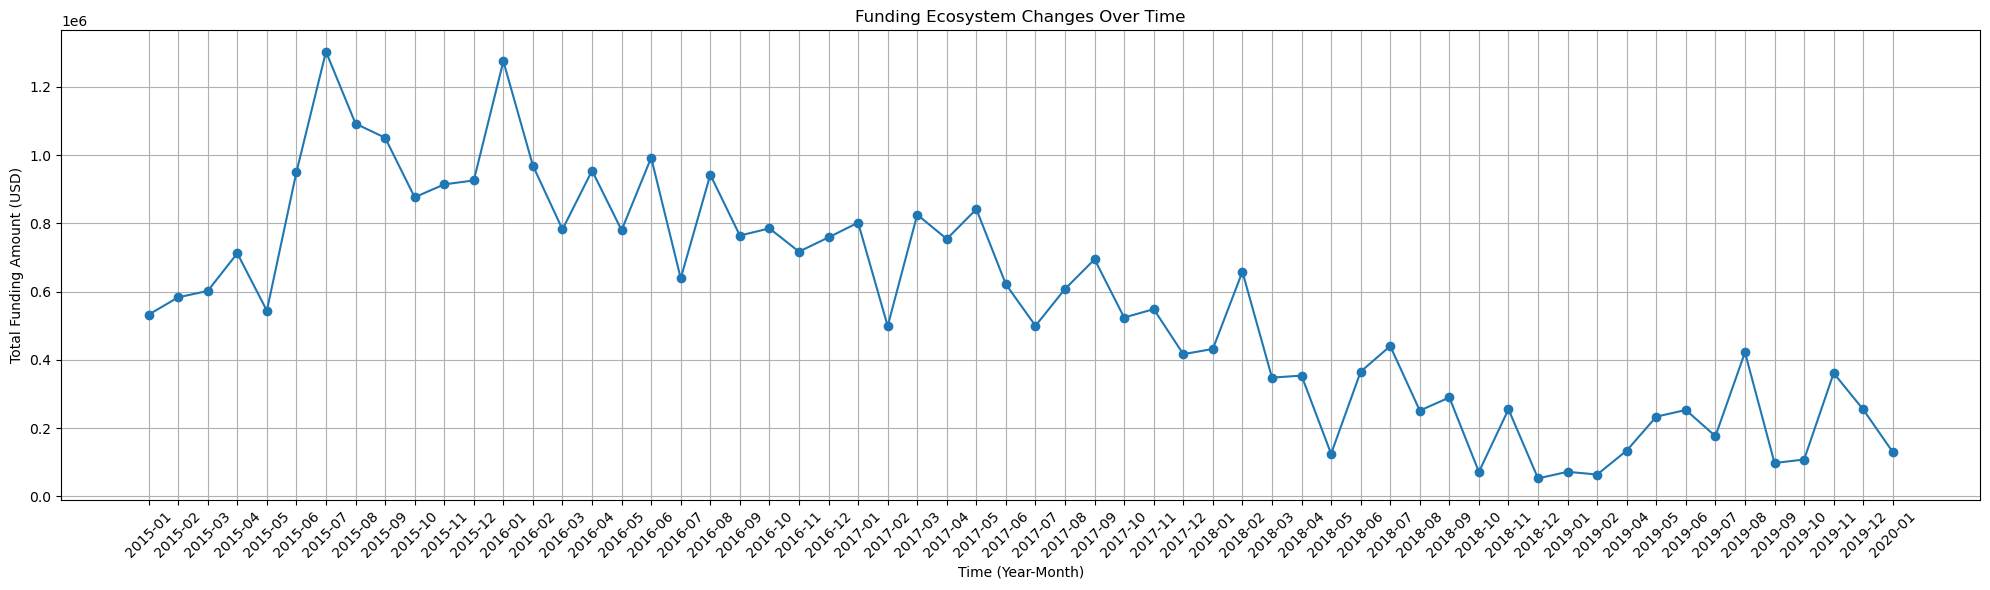

In [15]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Extract the year and month from the date
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Group by year and month and sum the funding amounts
monthly_funding = df.groupby(['Year', 'Month'])['Amount in USD'].sum().reset_index()
# monthly_funding.head(20)

# Create a new column for Year-Month
monthly_funding['Year-Month'] = monthly_funding['Year'].astype(str) + '-' + monthly_funding['Month'].astype(str).str.zfill(2)

# Sort by date
monthly_funding = monthly_funding.sort_values(by=['Year', 'Month'])

# Plotting the data
plt.figure(figsize=(20, 6))
plt.plot(monthly_funding['Year-Month'], monthly_funding['Amount in USD'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Time (Year-Month)')
plt.ylabel('Total Funding Amount (USD)')
plt.title('Funding Ecosystem Changes Over Time')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

We can see here that the total founding amount **decrease with the time**

### What is the General Amount that Startups get in India?

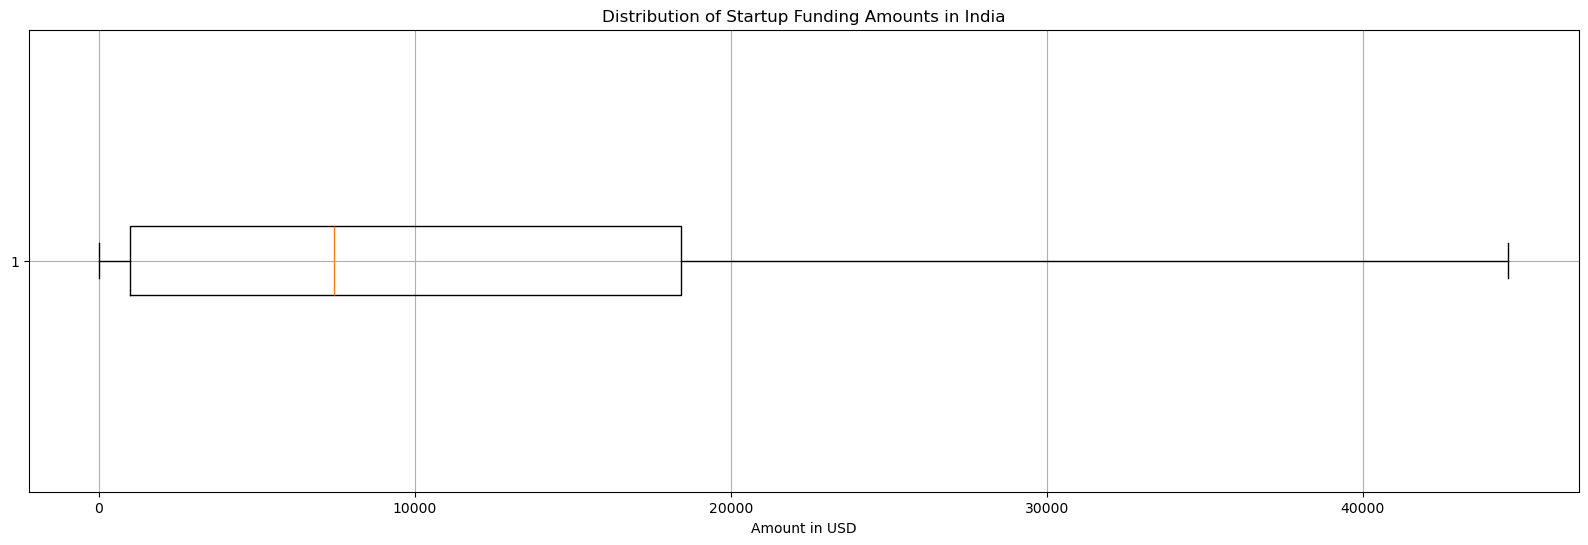

count     3042.000000
mean     11184.124227
std      11558.283731
min         16.000000
25%       1000.000000
50%       7450.000000
75%      18438.500000
max      44596.250000
Name: Amount in USD, dtype: float64

In [16]:
plt.figure(figsize=(20, 6))
plt.boxplot(df['Amount in USD'], vert=False)
plt.title('Distribution of Startup Funding Amounts in India')
plt.xlabel('Amount in USD')
plt.grid(True)
plt.show()
df['Amount in USD'].describe()


Most startups receive funding amounts between $1,000 and $18,438.50, with the median amount being $7,450. This indicates that half of the startups receive funding below $7,450,

#### Which Kind of Industries are more preferred for Startups?

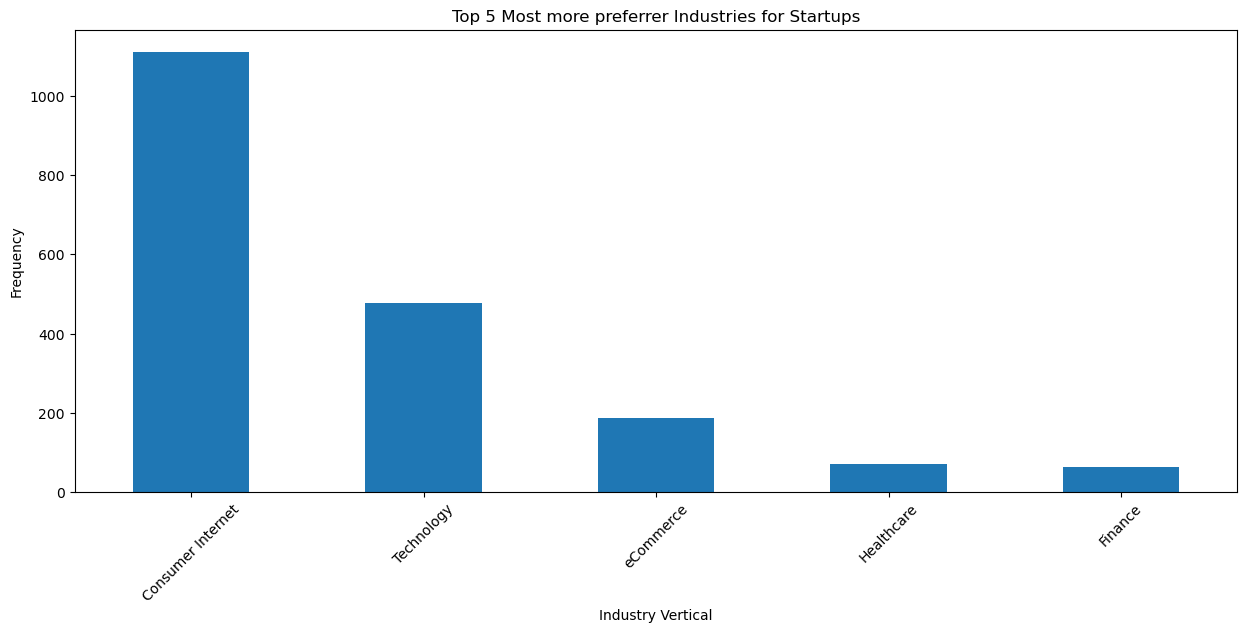

In [17]:
# There are  too many unique values in this column so I will list the top 5
top_5_values = df['Industry Vertical'].value_counts().nlargest(5)
# Plot the histogram
plt.figure(figsize=(15, 6))
top_5_values.plot(kind='bar')
plt.title(f'Top 5 Most more preferrer Industries for Startups')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### **Consumer internet** is the most preferred industry by startups

### Does Location also play a role, In determining the Growth of a Startup?


#### Let group the cities and see the mean and media values of the investment amount

<Figure size 1400x800 with 0 Axes>

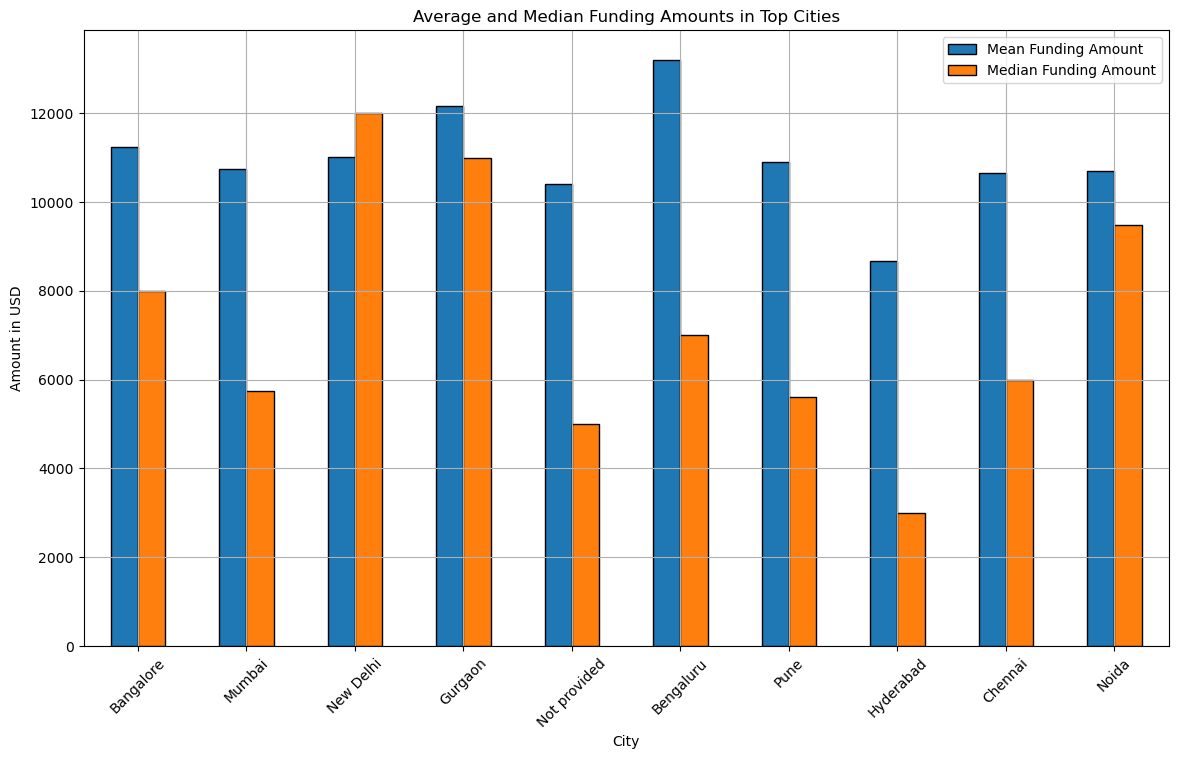

,mean,median,count
City Location,,,
Bangalore,11247.676214,8000.0,700
Mumbai,10749.922261,5750.0,566
New Delhi,11003.558551,12000.0,421
Gurgaon,12168.846516,11000.0,287
Not provided,10399.792500,5000.0,180
Bengaluru,13206.250355,7000.0,141
Pune,10910.176190,5600.0,105
Hyderabad,8676.812626,3000.0,99
Chennai,10643.250000,6000.0,97


In [18]:
location_stats = df.groupby('City  Location')['Amount in USD'].agg(['mean', 'median', 'count']).sort_values(by='count', ascending=False)

# Select the top 10 cities by the number of startups
top_cities = location_stats.head(10)

# Plot the mean and median funding amount for the top cities
plt.figure(figsize=(14, 8))
top_cities[['mean', 'median']].plot(kind='bar', figsize=(14, 8), edgecolor='black')
plt.title('Average and Median Funding Amounts in Top Cities')
plt.xlabel('City')
plt.ylabel('Amount in USD')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(['Mean Funding Amount', 'Median Funding Amount'])
plt.show()

top_cities

#### we can see here that the location does play an important role the growth of a startup, as indicated by the variation in the average and median funding amounts across different cities. 

### Who plays the main role in Indian Startups Ecosystem?

<Figure size 1400x800 with 0 Axes>

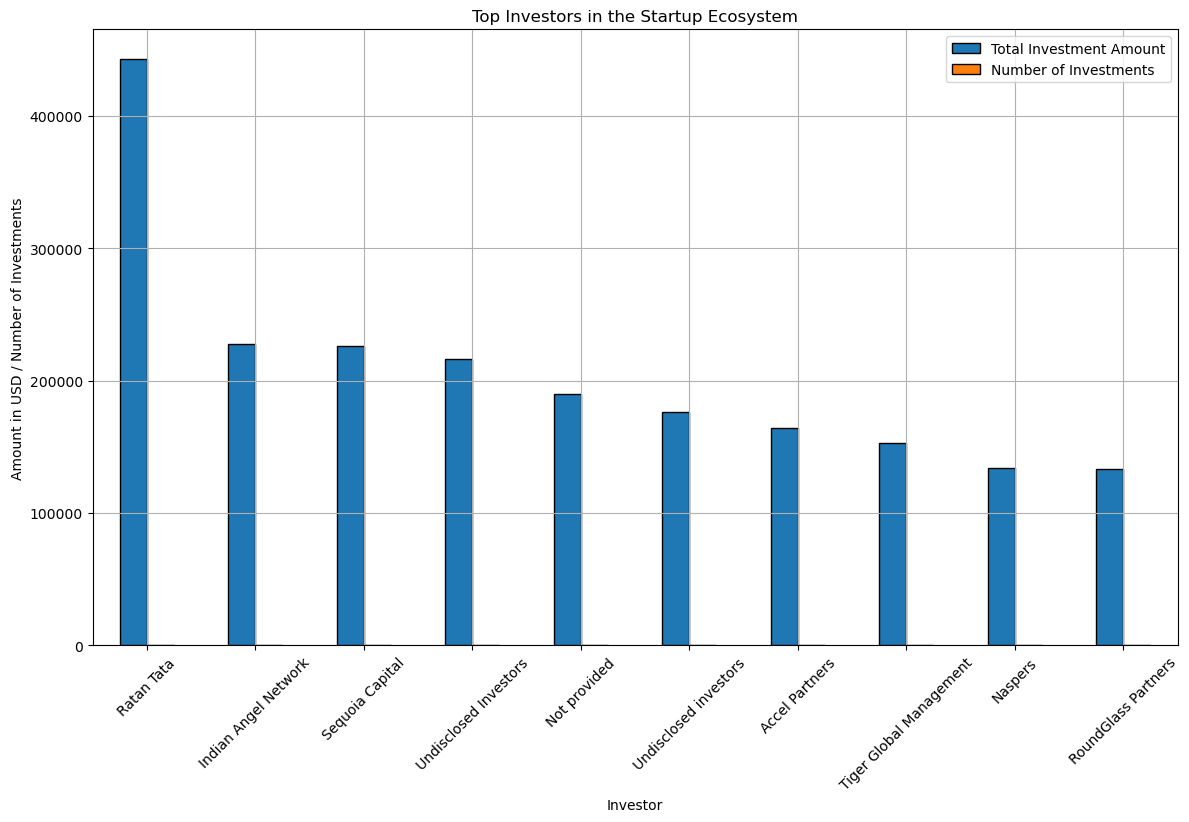

,sum,count
Investors Name,,
Ratan Tata,443059.00,25
Indian Angel Network,227572.00,23
Sequoia Capital,226323.25,15
Undisclosed Investors,216491.00,39
Not provided,190059.65,35
Undisclosed investors,176313.25,30
Accel Partners,164111.75,12
Tiger Global Management,152692.50,7
Naspers,133788.75,3


In [19]:
investor_stats = df.groupby('Investors Name')['Amount in USD'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)

# top 10 investors by total investment amount
top_investors = investor_stats.head(10)

plt.figure(figsize=(14, 8))
top_investors.plot(kind='bar', figsize=(14, 8), edgecolor='black')
plt.title('Top Investors in the Startup Ecosystem')
plt.xlabel('Investor')
plt.ylabel('Amount in USD / Number of Investments')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(['Total Investment Amount', 'Number of Investments'])
plt.show()

top_investors

#### **Ratan tata** is the one who invest more in startups so he plays the main role 

### What are the different Types of Funding for Startups?

In [20]:
funding_types = df['InvestmentnType'].value_counts()
funding_types

InvestmentnType
Private Equity                 1360
Seed Funding                   1353
Seed/ Angel Funding              60
Seed / Angel Funding             47
Seed\\nFunding                   30
Debt Funding                     25
Series A                         24
Seed/Angel Funding               23
Series B                         20
Series C                         14
Series D                         12
Angel / Seed Funding              8
Seed Round                        7
Private Equity Round              4
Pre-Series A                      4
Seed                              4
Seed / Angle Funding              3
Equity                            2
Venture Round                     2
pre-Series A                      2
Series E                          2
Corporate Round                   2
Series F                          2
Seed Funding Round                1
Private                           1
Private Funding                   1
Series H                          1
Series G    

### We can see here the different types of investment, I didn't use a graph for this because this way is more readable.